In [1]:
from utils import read_basin_data, get_basin_meta_data, prep_data
from tree_model import tree_model, get_leaves_and_groups

In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
basin = "upper_col"

In [3]:
df = read_basin_data(basin)
meta = get_basin_meta_data(basin)
    
reservoirs = meta[meta["group"] == "high_rt"].index
res_grouper = df.index.get_level_values(0)
df = df.loc[res_grouper.isin(reservoirs)]
# need to set it again after we trimmed the data set
res_grouper = df.index.get_level_values(0)
time_grouper = df.index.get_level_values(1)
X,y,means,std = prep_data(df)
X["sto_diff"] = X["storage_pre"] - X["storage_roll7"]

Time to run 'read_basin_data': 9.96200 seconds


In [4]:
max_depth = 3
random_state=37
tree = tree_model(X, y, max_depth=max_depth, random_state=random_state)
leaves, groups = get_leaves_and_groups(X, tree)
group_indices = {
    g:groups[groups == g].index for g in groups.unique()
}

In [5]:
formula = "release ~ release_pre + sto_diff + inflow + release_roll7 + \
            inflow_roll7 + storage_x_inflow"

In [6]:
import pymc3 as pm

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, storage_x_inflow, inflow_roll7, release_roll7, inflow, sto_diff, release_pre, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 121 seconds.


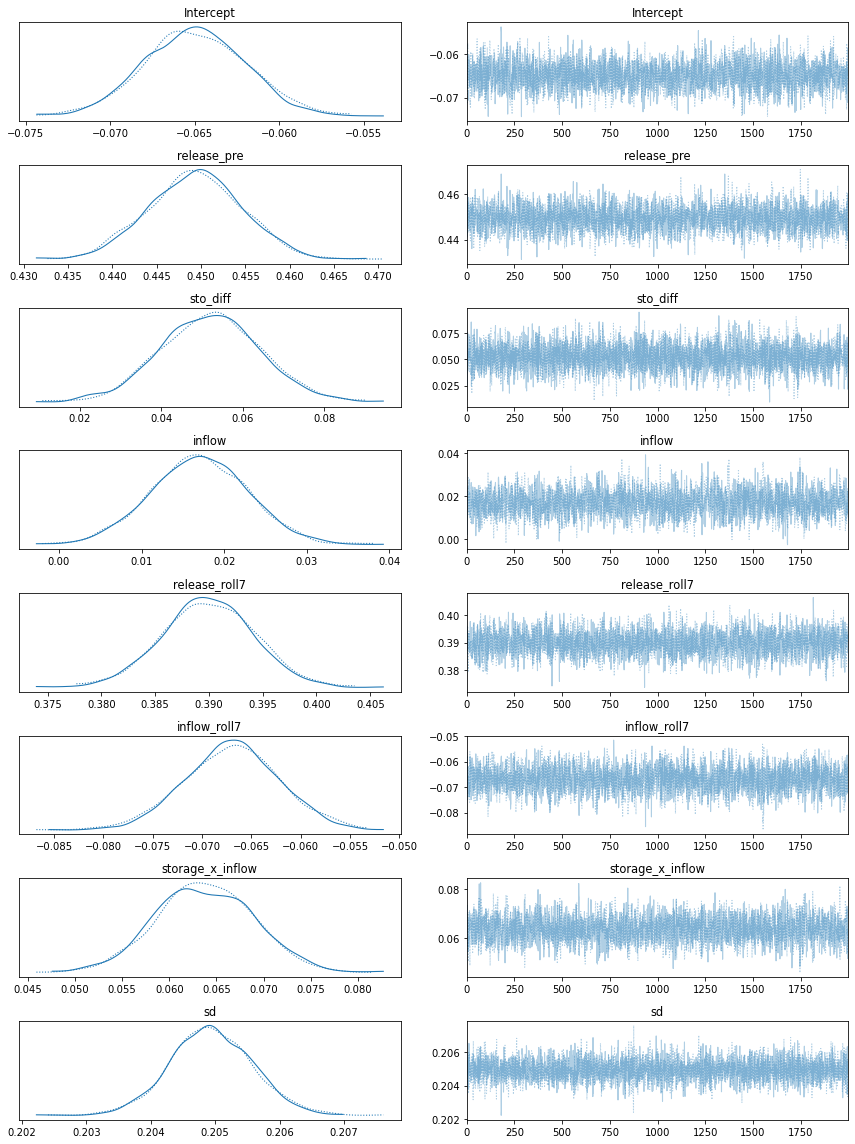

In [20]:
Xs = X.loc[group_indices[4]]
Xs["release"] = y.loc[group_indices[4]]

with pm.Model() as normal_model:
    family = pm.glm.families.Normal()
    
    pm.GLM.from_formula(formula, data=Xs, family=family)
    
    normal_trace = pm.sample(draws=2000, chains=2, tune=1000, cores=1, return_inferencedata=False)
    ax = pm.plot_trace(normal_trace)
    plt.tight_layout()
    plt.show()

In [36]:
for var in normal_trace.varnames:
    mean = normal_trace[var].mean()
    l = np.percentile(normal_trace[var], 2.5)
    u = np.percentile(normal_trace[var], 97.5)
    print(f"{var: <18s}: {l: 5.3f},{mean: 5.3f},{u: 5.3f}")

Intercept         : -0.071,-0.065,-0.059
release_pre       :  0.439, 0.449, 0.460
sto_diff          :  0.028, 0.052, 0.076
inflow            :  0.006, 0.017, 0.029
release_roll7     :  0.381, 0.390, 0.398
inflow_roll7      : -0.076,-0.067,-0.058
storage_x_inflow  :  0.054, 0.064, 0.074
sd_log__          : -1.591,-1.585,-1.579
sd                :  0.204, 0.205, 0.206


In [7]:
group_indices

{6: MultiIndex([(     'MCPHEE', '1998-09-24'),
             (     'MCPHEE', '1998-09-25'),
             (     'MCPHEE', '1998-09-26'),
             (     'MCPHEE', '1998-09-27'),
             (     'MCPHEE', '1998-09-28'),
             (     'MCPHEE', '1998-09-29'),
             (     'MCPHEE', '1998-09-30'),
             (     'MCPHEE', '1998-10-01'),
             (     'MCPHEE', '1998-10-02'),
             (     'MCPHEE', '1998-10-03'),
             ...
             ('LAKE POWELL', '2021-08-22'),
             ('LAKE POWELL', '2021-08-24'),
             ('LAKE POWELL', '2021-08-25'),
             ('LAKE POWELL', '2021-08-26'),
             ('LAKE POWELL', '2021-08-27'),
             ('LAKE POWELL', '2021-08-28'),
             ('LAKE POWELL', '2021-08-29'),
             ('LAKE POWELL', '2021-08-30'),
             ('LAKE POWELL', '2021-08-31'),
             ('LAKE POWELL', '2021-09-01')],
            names=['site_name', 'datetime'], length=37649),
 11: MultiIndex([(     'MCPHEE', '1999-